In [1]:
import torch
import torch, torchaudio, glob
import random
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

def seed_everything(seed):      
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

class FeedForward(torch.nn.Module):
    def __init__(self, d_model=512, d_ff=1024, dropout=0.1, **kwargs):
        super().__init__()
        self.ff = torch.nn.Sequential(
            torch.nn.LayerNorm(d_model),
            torch.nn.Linear(d_model, d_ff),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(d_ff, d_model),
        )
        
    def forward(self, x):
        return self.ff(x)

class SelfAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads=8, d_head=64, dropout=0.1, **kwargs):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head
        self.scale = torch.sqrt(torch.tensor(d_head, dtype=torch.float32))
        self.norm = torch.nn.LayerNorm(d_model)
        self.q_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.v_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.k_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.dropout = torch.nn.Dropout(dropout)
        self.out = torch.nn.Linear(d_head*n_heads, d_model)

    def forward(self, x):
        x = self.norm(x)
        b = x.shape[0]
        q = self.q_linear(x).view(b, -1, self.n_heads, self.d_head)
        k = self.k_linear(x).view(b, -1, self.n_heads, self.d_head)
        v = self.v_linear(x).view(b, -1, self.n_heads, self.d_head) 

        scores = torch.einsum('bihd,bjhd->bhij', q, k) / self.scale
     
        att = scores.softmax(dim=-1)
        att = self.dropout(att)

        out = torch.einsum('bhij,bjhd->bihd', att, v).reshape(b, -1, self.n_heads*self.d_head)
        out = self.dropout(out)
        out = self.out(out)
        return out

class Encoder(torch.nn.Module):
    def __init__(self, nb_layers=6, seq_len=400, **kwargs):
        super().__init__()        
        self.pos = torch.nn.Parameter(torch.randn(1, seq_len, kwargs['d_model']))
        self.att = torch.nn.ModuleList([SelfAttention(**kwargs) for _ in range(nb_layers)])
        self.ff = torch.nn.ModuleList([FeedForward(**kwargs) for _ in range(nb_layers)])
        
    def forward(self, x):
        b, t, d = x.shape
        x = x + self.pos[:, :t, :]
        for att, ff in zip(self.att, self.ff):
            x = x + att(x)
            x = x + ff(x)            
        return x


class CausalSelfAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads=8, d_head=64, dropout=0.1, seq_len=400, **kwargs):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head
        self.scale = torch.sqrt(torch.tensor(d_head, dtype=torch.float32))
        self.norm = torch.nn.LayerNorm(d_model)
        self.q_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.v_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.k_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.dropout = torch.nn.Dropout(dropout)
        self.out = torch.nn.Linear(d_head*n_heads, d_model)
        
        self.register_buffer("mask", torch.tril(torch.ones(seq_len, seq_len)).view(1, 1, seq_len, seq_len) == 0)
            

    def forward(self, x):
        x = self.norm(x)
        b, n, d = x.shape
        q = self.q_linear(x).view(b, -1, self.n_heads, self.d_head)
        k = self.k_linear(x).view(b, -1, self.n_heads, self.d_head)
        v = self.v_linear(x).view(b, -1, self.n_heads, self.d_head) 

        scores = torch.einsum('bihd,bjhd->bhij', q, k) / self.scale
        
        scores = scores.masked_fill(self.mask[:,:,:n,:n], float('-inf'))
        att = scores.softmax(dim=-1)
        att = self.dropout(att)

        out = torch.einsum('bhij,bjhd->bihd', att, v).reshape(b, -1, self.n_heads*self.d_head)
        out = self.dropout(out)
        out = self.out(out)
        return out

class CrossAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads=8, d_head=64, dropout=0.1, **kwargs):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head
        self.scale = torch.sqrt(torch.tensor(d_head, dtype=torch.float32))
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.q_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.v_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.k_linear = torch.nn.Linear(d_model, d_head*n_heads)
        self.dropout = torch.nn.Dropout(dropout)
        self.out = torch.nn.Linear(d_head*n_heads, d_model)
    
    def forward(self, x1, x2):
        x1 = self.norm1(x1)
        x2 = self.norm2(x2)  
        b = x1.shape[0]
        q = self.q_linear(x1).view(b, -1, self.n_heads, self.d_head)
        k = self.k_linear(x2).view(b, -1, self.n_heads, self.d_head)
        v = self.v_linear(x2).view(b, -1, self.n_heads, self.d_head) 

        scores = torch.einsum('bihd,bjhd->bhij', q, k) / self.scale
     
        att = scores.softmax(dim=-1)
        att = self.dropout(att)

        out = torch.einsum('bhij,bjhd->bihd', att, v).reshape(b, -1, self.n_heads*self.d_head)
        out = self.dropout(out)
        out = self.out(out)
        return out, att
    
class Decoder(torch.nn.Module):
    def __init__(self, nb_layers=6, seq_len=400, **kwargs):
        super().__init__()        
        self.pos = torch.nn.Parameter(torch.randn(1, seq_len, kwargs['d_model']))
        self.att = torch.nn.ModuleList([CausalSelfAttention(**kwargs) for _ in range(nb_layers)])
        self.cross_att = torch.nn.ModuleList([CrossAttention(**kwargs) for _ in range(nb_layers)])
        self.ff = torch.nn.ModuleList([FeedForward(**kwargs) for _ in range(nb_layers)])
        
    def forward(self, x, enc):
        b, t, d = x.shape
        x = x + self.pos[:, :t, :]
        for att, cross_att, ff in zip(self.att, self.cross_att, self.ff):
            x = x + att(x)
            x = x + cross_att(x, enc)[0]
            x = x + ff(x)            
        return x

class SpecAug(torch.nn.Module):
    def __init__(self, prob_t_warp=0.5,
                       t_factor=(0.9, 1.1), 
                       f_mask_width = (0, 8), 
                       t_mask_width = (0, 10),
                       nb_f_masks=[1,2], 
                       nb_t_masks=[1,2], 
                       ):
        super().__init__()
        self.t_factor = t_factor
        self.f_mask_width = f_mask_width
        self.t_mask_width = t_mask_width
        self.nb_f_masks = nb_f_masks
        self.nb_t_masks = nb_t_masks
        self.prob_t_warp = prob_t_warp

    def time_warp(self, x):
        x = torch.nn.functional.interpolate(x, size=(int(x.shape[2]*np.random.uniform(*self.t_factor)), ))
        # print('warp', x.shape[2])
        return x
    
    def freq_mask(self, x):
        for _ in range(np.random.randint(*self.nb_f_masks)):
            f = np.random.randint(*self.f_mask_width)
            f0 = np.random.randint(0, x.shape[1]-f)
            # print('f', f0, f0+f)
            x[:,f0:f0+f,:] = 0
        return x

    def time_mask(self, x):
        for _ in range(np.random.randint(*self.nb_t_masks)):
            t = np.random.randint(*self.t_mask_width)
            t0 = np.random.randint(0, x.shape[2]-t)
            # print('t', t0, t0+t)
            x[:,:,t0:t0+t] = 0
        return x

    def forward(self, x):
        if np.random.uniform() < self.prob_t_warp:
            x = self.time_warp(x)
        x = self.freq_mask(x)
        x = self.time_mask(x)
        return x



class AudioFeatures(torch.nn.Module):
    def __init__(self, feat_dim=80, d_model=512, **kwargs):
        super().__init__()
        self.fe = torchaudio.transforms.MelSpectrogram(
                        n_fft=512, 
                        win_length=25*16, 
                        hop_length=10*16, 
                        n_mels=feat_dim)                            # 25ms window, 10ms shift
        self.spec_aug = SpecAug()
        self.linear = torch.nn.Linear(feat_dim, d_model)

    def forward(self, x): 
        x = self.fe(x)        
        x = (x+1e-6).log()
        if self.training:
            x = self.spec_aug(x)
        x = x.transpose(1, 2)
        x = self.linear(x)
        return x

class AudioTransformer(torch.nn.Module):
    def __init__(self, vocab_size=24, **kwargs):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = kwargs['seq_len']

        self.fe = AudioFeatures(**kwargs)
        self.enc = Encoder(**kwargs)
        
        self.emb = torch.nn.Embedding(vocab_size, kwargs['d_model'])
        self.dec = Decoder(**kwargs)
        self.out = torch.nn.Linear(kwargs['d_model'], vocab_size)
        

    def encoder(self, x):
        x = self.fe(x)
        return self.enc(x)

    def decoder(self, y, enc):
        y = self.emb(y)
        dec = self.dec(y, enc)
        return self.out(dec)
    
    def forward(self, x, y):
        enc = self.encoder(x)
        return self.decoder(y, enc)
                
    def loss(self, x, y):        
        logits = self(x, y[:,:-1])
        target = y[:,1:]
        loss = torch.nn.functional.cross_entropy(logits.reshape(-1, self.vocab_size), 
                                                 target.reshape(-1))
        return loss
    
           
    def generate(self, x):
        device = next(self.parameters()).device
        self.eval()
        x = torch.nn.functional.pad(torch.tensor(x), (0, self.seq_len-len(x)), value=23)        
        if len(x.shape) == 1:
            x = x[None, :]
        y = [20,]
        with torch.no_grad():            
            enc = self.encoder(x.to(device))   
            
            while y[-1] != 22 and len(y) < self.seq_len:
                logits = self.decoder(torch.tensor(y).unsqueeze(0).to(device), enc)
                y.append(logits.argmax(-1)[:,-1].item())
                            
        return y
    

# dataset 

In [2]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir='data3/test', audio_len=4*16000, seq_len=10):
        self.audio_len = audio_len  
        self.seq_len = seq_len     
        self.files = sorted(glob.glob(data_dir+'/*.wav'))        
        print(len(self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        x, fs = torchaudio.load(self.files[idx])
        if x.shape[1] < self.audio_len:
            x = torch.nn.functional.pad(x, (0, self.audio_len-x.shape[1]), value=0)
        else:
            x = x[:, :self.audio_len]

        x = x[0]
        label = self.files[idx].split('.')[-2].split('_')[-1]
        # print(x.shape, x.dtype)
        label = label.replace('o', '0')
        label = [int(d) for d in str(label)]
        y = [20, ] + label + [22, ]
        y = torch.nn.functional.pad(torch.tensor(y), (0, self.seq_len-len(y)), value=23)
        return x, y

testset = TestDataset()


###
# train the network
###
model = AudioTransformer(vocab_size=24, d_model=256, nb_layers=8, 
                         d_ff=512, n_heads=8, d_head=32, dropout=0.1, seq_len=500)

print(model.generate( torch.randn(1, 64000 ) ))
# input()
device = 'cuda'
model.to(device)
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# nb_epochs = 20
# batch_size = 32
# model.train()
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# for e in range(nb_epochs):
#     loss_sum = 0
#     for x, y in trainloader:
#         x = x.to(device)
#         y = y.to(device)
#         opt.zero_grad()
#         loss = model.loss(x, y)
#         loss.backward()
#         opt.step()
#         loss_sum += loss.item()
#     print(f'epoch {e} loss {loss_sum/len(trainloader):.2f}')

# model, opt = torch.load('model82.pt')
#load state space
model.load_state_dict(torch.load('model82.pt'))

2000


/tmp/ipykernel_31337/372656654.py:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.nn.functional.pad(torch.tensor(x), (0, self.seq_len-len(x)), value=23)


[20, 7, 10, 9, 6, 16, 17, 4, 8, 10, 7, 4, 15, 0, 10, 7, 6, 16, 17, 14, 20, 6, 6, 2, 1, 10, 9, 22]


<All keys matched successfully>

# test the network

In [3]:
model.eval()
# import editdistance
# err = 0
# num = 0
# for i,(x, y) in enumerate(testset):
#     print('(%d/%d)' % (i, len(testset)) )
#     x = x.to(device)    
#     y_pred = model.generate(x[None,...])
#     hyp = ' '.join([str(i) for i in y_pred[1:-1]])
#     y = y.numpy().tolist()
#     # find the first 22 in list y
#     y = y[:y.index(22)]
#     ref = ' '.join([str(i) for i in y[1:]])
#     # edit distance
#     print('ref', ref)
#     print('hyp', hyp)    
#     err += editdistance.eval(hyp, ref)
#     num += len(ref.split())  
# print('error rate: %.4f' % (err/num))



att_ = [None] *  len(model.dec.cross_att )
for i, cross_att in enumerate(model.dec.cross_att):
    cross_att.register_forward_hook(
        lambda _, ins, outs, index=i: att_.__setitem__(index, outs[-1])
    )

visualize attention

/tmp/ipykernel_31337/372656654.py:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.nn.functional.pad(torch.tensor(x), (0, self.seq_len-len(x)), value=23)


ref 5 2 6
hyp 5 2 6


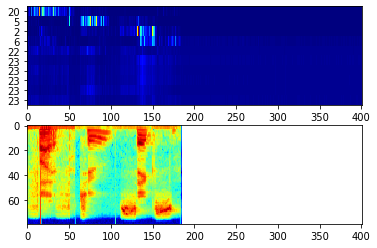

In [4]:
x, y = testset[600]
x = x.to(device)
y = y.to(device)
y_pred = model.generate(x[None,...])
model(x[None,:], y[None,:]) 
hyp = ' '.join([str(i) for i in y_pred[1:-1]])
y = y.cpu().numpy().tolist()
y0 = y
y = y[:y.index(22)]
ref = ' '.join([str(i) for i in y[1:]])
print('ref', ref)
print('hyp', hyp)

a = torch.cat(att_)

plt.clf()
a = a.mean([0, 1])
plt.imshow(a.cpu().detach().numpy(), interpolation='none', cmap='jet', aspect='auto')
ax = plt.gca()
ax.set_yticks(np.arange(len(y0)), y0)

plt.clf()
plt.subplot(2,1,1)
plt.imshow(a.cpu().detach().numpy(), interpolation='none', cmap='jet', aspect='auto')
ax = plt.gca()
ax.set_yticks(np.arange(len(y0)), y0)
plt.subplot(2,1,2)
plt.imshow( model.fe.fe(x).log().detach().cpu().numpy(), interpolation='none', cmap='jet', aspect='auto')

visualize attention

ref 9 1 7 1
hyp 9 1 7 1


/tmp/ipykernel_31337/372656654.py:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.nn.functional.pad(torch.tensor(x), (0, self.seq_len-len(x)), value=23)


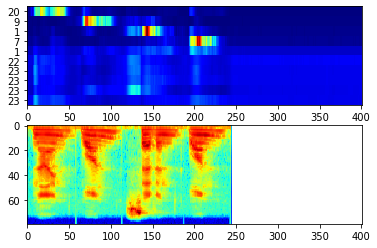

In [5]:
x, y = testset[700]
x = x.to(device)
y = y.to(device)
y_pred = model.generate(x[None,...])
model(x[None,:], y[None,:]) 
hyp = ' '.join([str(i) for i in y_pred[1:-1]])
y = y.cpu().numpy().tolist()
y0 = y
y = y[:y.index(22)]
ref = ' '.join([str(i) for i in y[1:]])
print('ref', ref)
print('hyp', hyp)

a = torch.cat(att_)

plt.clf()
a = a.mean([0, 1])
plt.imshow(a.cpu().detach().numpy(), interpolation='none', cmap='jet', aspect='auto')
ax = plt.gca()
ax.set_yticks(np.arange(len(y0)), y0)

plt.clf()
plt.subplot(2,1,1)
plt.imshow(a.cpu().detach().numpy(), interpolation='none', cmap='jet', aspect='auto')
ax = plt.gca()
ax.set_yticks(np.arange(len(y0)), y0)
plt.subplot(2,1,2)
plt.imshow( model.fe.fe(x).log().detach().cpu().numpy(), interpolation='none', cmap='jet', aspect='auto')



from scipy.ndimage import median_filter
a = median_filter(torch.cat(att_).cpu().detach().numpy(), (1, 1, 1, 7))
plt.clf()
a = torch.tensor(a).mean([0, 1])
plt.subplot(2,1,1)
plt.imshow(a.cpu().detach().numpy(), interpolation='none', cmap='jet', aspect='auto')
ax = plt.gca()
ax.set_yticks(np.arange(len(y0)), y0)
plt.subplot(2,1,2)
plt.imshow( model.fe.fe(x).log().detach().cpu().numpy(), interpolation='none', cmap='jet', aspect='auto')